**The Problem Statement**

An online grocery store wants you to meet with some of the best customers and identify the ID of the customers who bought the most items in their lifetime, and the ID for the customer who bought each product the most. Further, we are required to cluster items based on co-purchase history. Each item belongs to only one cluster, and items in a cluster have the highest chance of being bought together.


In [9]:
import warnings
warnings.simplefilter('ignore')

%matplotlib inline

from collections import Counter

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Load Data

In [2]:
item_to_id = pd.read_csv('item_to_id.csv')
item_to_id.head()

,Item_name,Item_id
0,coffee,43
1,tea,23
2,juice,38
3,soda,9
4,sandwich loaves,39


In [3]:
#check info, if any missing values
item_to_id.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48 entries, 0 to 47
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Item_name  48 non-null     object
 1   Item_id    48 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 896.0+ bytes


In [6]:
# check null entries

item_to_id.isnull().sum()

Item_name    0
Item_id      0
dtype: int64

In [4]:
purchase_history = pd.read_csv('purchase_history.csv')
purchase_history.head()

,user_id,id
0,222087,"27,26"
1,1343649,"6,47,17"
2,404134,"18,12,23,22,27,43,38,20,35,1"
3,1110200,"9,23,2,20,26,47,37"
4,224107,"31,18,5,13,1,21,48,16,26,2,44,32,20,37,42,35,4..."


In [5]:
purchase_history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39474 entries, 0 to 39473
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  39474 non-null  int64 
 1   id       39474 non-null  object
dtypes: int64(1), object(1)
memory usage: 616.9+ KB


In [7]:
# check null entries

purchase_history.isnull().sum()

user_id    0
id         0
dtype: int64

# Preprocessing

## User-Item Count Matrix

The idea is to build a matrix that stores the user ids x item ids, and counts the number of items bought by each user. Will help solving the first part of the problem.

In [8]:
#number of unique ids

print(sorted(item_to_id['Item_id'].unique()))

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48]


In [12]:
def id_to_item(df):
    item_ids = df['id'].str.split(',').sum()
    #here, the sum combines two lists into one big one
    return pd.Series(Counter(int(id) for id in item_ids))

In [14]:
#user item count matrix

user_item_count = purchase_history.groupby('user_id').apply(id_to_item).unstack(fill_value=0)


In [16]:
user_item_count.shape

(24885, 48)

In [17]:
user_item_count.head()

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
user_id,,,,,,,,,,,,,,,,,,,,,
47,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,1,1,0,0
68,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,0
113,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,1,0,0
123,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
223,1,1,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0


# Question 1.1 Customer who bought the most products

In [22]:
user_count = user_item_count.sum(axis= 1)
print('The customer who bought the most items has ID {} and they bought {} items'.format(user_count.argmax(), 
                                                                                         user_count.max()))

The customer who bought the most items has ID 4445 and they bought 72 items


# Question 1.2 The customer who bought the most of each item

In [26]:
item_user_most = user_item_count.apply(np.argmax, axis=0).reset_index()
item_user_most = item_user_most.rename(columns={'index': 'Item_id', 0: 'User_id'})


In [25]:
df = pd.merge(left=item_user_most, right=item_to_id, on='Item_id', how='left')
df[['Item_id', 'Item_name', 'User_id']]

,Item_id,Item_name,User_id
0,1,sugar,512
1,2,lettuce,512
2,3,pet items,2552
3,4,baby items,92
4,5,waffles,3605
5,6,poultry,5555
6,7,sandwich bags,2926
7,8,butter,2493
8,9,soda,4445
9,10,carrots,10238


# Question 2: Clustering

## Building Feature Matrix

In [27]:
#define item_id x user_id Feature matrix

feature_matrix = user_item_count.T
feature_matrix.head()

user_id,47,68,113,123,223,281,323,394,420,453,...,1499502,1499523,1499563,1499702,1499727,1499730,1499778,1499797,1499817,1499974
1,0,0,0,0,1,0,1,1,0,1,...,0,0,1,0,0,0,0,0,1,0
2,1,0,0,0,1,0,0,1,1,1,...,1,0,1,0,0,0,1,0,2,0
3,1,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## Choosing the optimal number of clusters
We look at how the cost function changes as the number of clusters change

In [29]:
clusters = range(2,30)
inertias = []
silhouettes = [] #Lower=Better
#Silhouette coefficients (as these values are referred to as) near +1 indicate that 
#the sample is far away from the neighboring clusters.
#A value of 0 indicates that the sample is on or very close to the decision boundary 
#between two neighboring clusters and negative values indicate that those samples might 
#have been assigned to the wrong cluster.

for n in clusters:
    #init is a way to speed up convergence, n_jobs = -1 (or none) means use all processors
    kmeans = KMeans(n_clusters = n, init ='k-means++', random_state = 42, n_jobs=-1)
    kmeans = kmeans.fit(feature_matrix)
    label = kmeans.predict(feature_matrix)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(feature_matrix, label))

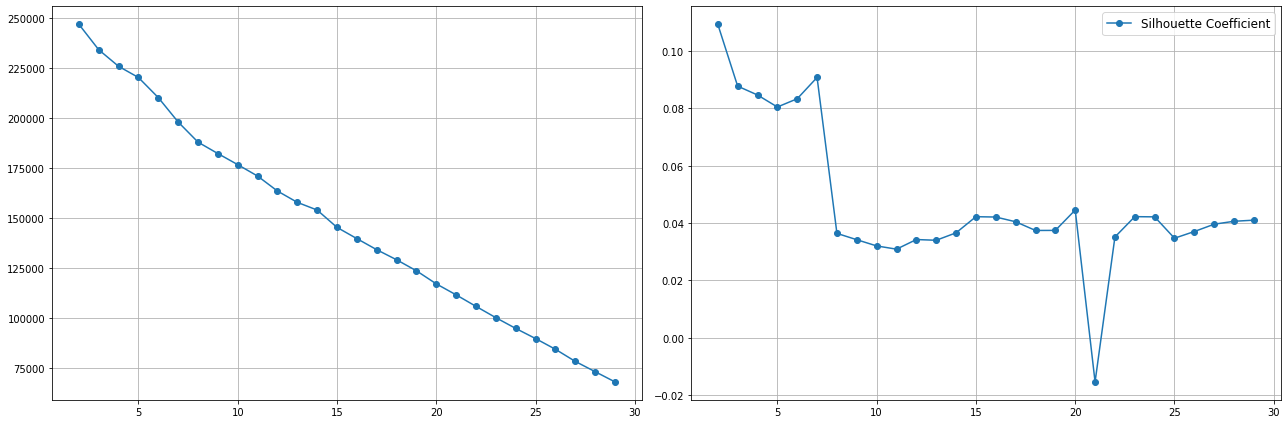

In [30]:

# visualization
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))
ax[0].plot(clusters, inertias, 'o-', label='Sum of Squared Distances')
ax[0].grid(True)
ax[1].plot(clusters, silhouettes, 'o-', label='Silhouette Coefficient')
ax[1].grid(True)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

21 clusters seems like the optimal number of clusters

## Building K Means Model

In [32]:
kmeans = KMeans(n_clusters=21, init='k-means++', random_state=42, n_jobs=-1)
kmeans = kmeans.fit(feature_matrix)
label = kmeans.predict(feature_matrix)

## PCA for Dimensionality Reduction

In [33]:
pca = PCA(n_components=2, random_state=42)
pca = pca.fit(feature_matrix)
pca_feature = pca.transform(feature_matrix)

In [35]:
pca_feature.shape

(48, 2)

# Visualise Clusters

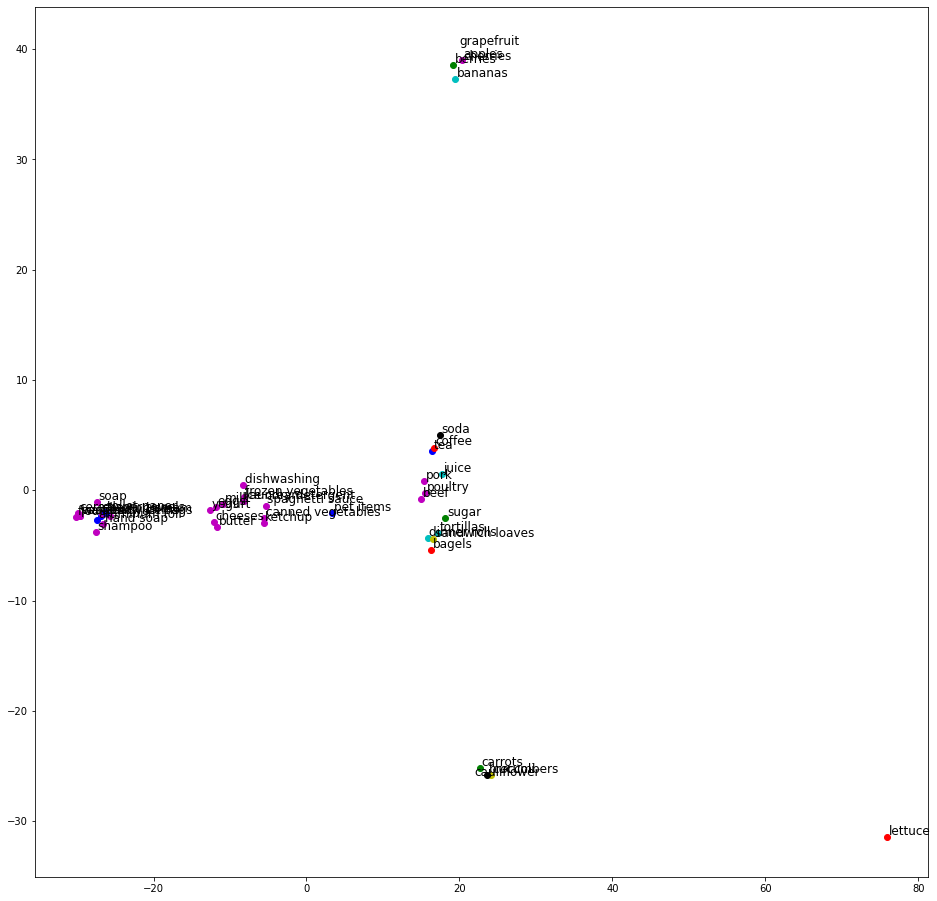

In [36]:

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

fig, ax = plt.subplots(figsize=(16, 16))
for j in range(len(pca_feature)):
    x = pca_feature[j][0]
    y = pca_feature[j][1]
    ax.plot(x, y, 'o', color=colors[label[j] % 8])
    name = item_to_id[item_to_id['Item_id'] == j + 1]['Item_name']
    ax.annotate(xy=(x+0.2, y+0.2), s=name.values[0], fontsize=12)

plt.show()

In [37]:
df = pd.DataFrame({'Item_id': list(range(1, 49)), 'label': label})
df = pd.merge(left=df, right=item_to_id, on='Item_id', how='left')

for i in range(0, 21):
    print(i, '\t', list(df[df['label'] == i]['Item_name']))

0 	 ['sandwich bags', 'aluminum foil', 'paper towels', 'toilet paper']
1 	 ['sugar']
2 	 ['bagels']
3 	 ['juice']
4 	 ['baby items', 'waffles', 'butter', 'cereals', 'shampoo', 'eggs', 'milk', 'laundry detergent', 'shaving cream', 'cheeses', 'frozen vegetables', 'spaghetti sauce', 'dishwashing ', 'canned vegetables', 'hand soap', 'flour', 'pasta', 'soap', 'ice cream', 'ketchup', 'yogurt']
5 	 ['cucumbers']
6 	 ['broccoli']
7 	 ['cauliflower']
8 	 ['tea']
9 	 ['berries']
10 	 ['lettuce']
11 	 ['bananas']
12 	 ['poultry', 'beef', 'pork']
13 	 ['sandwich loaves']
14 	 ['soda']
15 	 ['grapefruit', 'cherries']
16 	 ['pet items']
17 	 ['carrots']
18 	 ['coffee']
19 	 ['tortillas', 'dinner rolls']
20 	 ['apples']
